<a href="https://colab.research.google.com/github/anandhakumar222/Arrays/blob/main/Spam_Email.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
df = pd.read_excel('/content/spam.csv.xlsx')
print("Shape:", df.shape)
print(df.head())

# Remove unnecessary unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename columns (v1 = label, v2 = message)
if 'v1' in df.columns and 'v2' in df.columns:
    df = df.rename(columns={'v1': 'label', 'v2': 'text'})

Shape: (4949, 5)
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [7]:
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
print("After cleaning shape:", df.shape)


After cleaning shape: (4613, 2)


In [8]:
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
print("Label classes:", list(le.classes_))

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
one_hot_labels = ohe.fit_transform(df[['label_enc']])
one_hot_df = pd.DataFrame(one_hot_labels, columns=ohe.get_feature_names_out(['label_enc']))
df = pd.concat([df, one_hot_df], axis=1)
print("✅ One-Hot Encoded Columns Added")
print(df.head())

Label classes: ['ham', 'spam']
✅ One-Hot Encoded Columns Added
  label                                               text  label_enc  \
0   ham  Go until jurong point, crazy.. Available only ...        0.0   
1   ham                      Ok lar... Joking wif u oni...        0.0   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        1.0   
3   ham  U dun say so early hor... U c already then say...        0.0   
4   ham  Nah I don't think he goes to usf, he lives aro...        0.0   

   label_enc_0  label_enc_1  
0          1.0          0.0  
1          1.0          0.0  
2          0.0          1.0  
3          1.0          0.0  
4          1.0          0.0  


In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string for non-string inputs
    text = text.lower()
    text = re.sub(r'https?://\\S+|www\\.\\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\\s]', ' ', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
print(df[['label', 'clean_text']].head())

  label                                         clean_text
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham                nah think go usf life around though


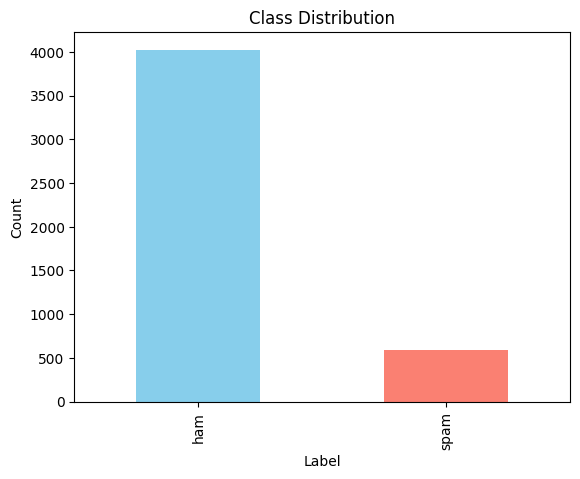

In [10]:
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

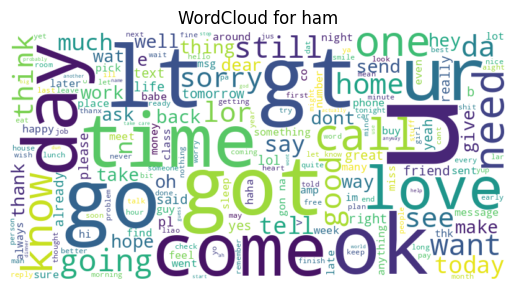

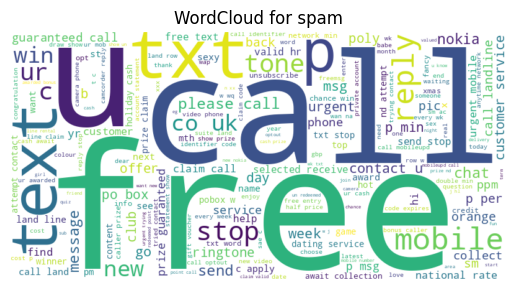

No text available for word cloud for label: nan


In [11]:
for lbl in df['label'].unique():
    text_for_wordcloud = ' '.join(df[df['label'] == lbl]['clean_text'])
    if text_for_wordcloud: # Check if the string is not empty
        wc = WordCloud(width=800, height=400, background_color='white').generate(
            text_for_wordcloud
        )
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for {lbl}')
        plt.show()
    else:
        print(f"No text available for word cloud for label: {lbl}")

In [12]:
# Drop rows with NaN in the 'label_enc' column
df.dropna(subset=['label_enc'], inplace=True)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])
y = df['label_enc']

print("X shape:", X.shape)

X shape: (4613, 5000)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3690, 5000) Test shape: (923, 5000)


In [14]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9729144095341279
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       806
        spam       1.00      0.79      0.88       117

    accuracy                           0.97       923
   macro avg       0.98      0.89      0.93       923
weighted avg       0.97      0.97      0.97       923



In [15]:
df.to_csv('/content/spam_preprocessed.csv', index=False)
print("✅ Saved preprocessed file as spam_preprocessed.csv")

✅ Saved preprocessed file as spam_preprocessed.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

In [17]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print("✅ Logistic Regression Accuracy:", accuracy * 100)

✅ Logistic Regression Accuracy: 95.55796316359697


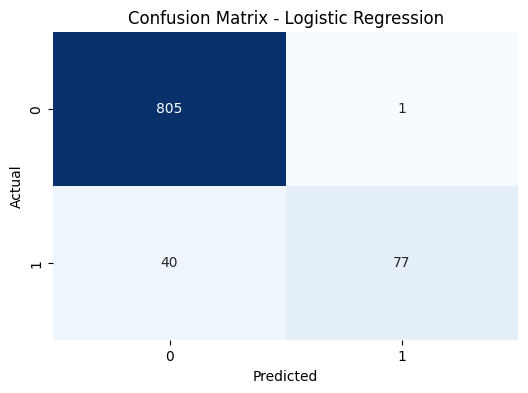

In [18]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
# Detailed Report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_lr))


🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       806
         1.0       0.99      0.66      0.79       117

    accuracy                           0.96       923
   macro avg       0.97      0.83      0.88       923
weighted avg       0.96      0.96      0.95       923



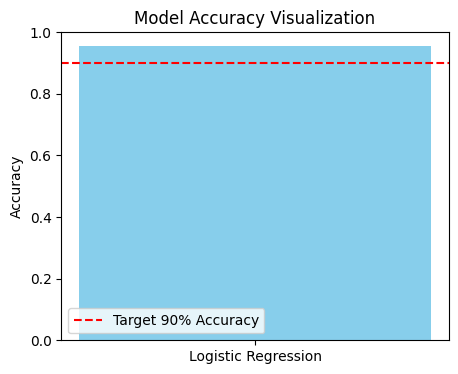

In [20]:
plt.figure(figsize=(5,4))
plt.bar(['Logistic Regression'], [accuracy], color='skyblue')
plt.axhline(0.9, color='red', linestyle='--', label='Target 90% Accuracy')
plt.title('Model Accuracy Visualization')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [21]:
# Import the library
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train the Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Predict on test data
y_pred_mnb = mnb.predict(X_test)

# Calculate accuracy
mnb_accuracy = accuracy_score(y_test, y_pred_mnb)
print("✅ Multinomial Naive Bayes Accuracy:", mnb_accuracy * 100)

✅ Multinomial Naive Bayes Accuracy: 97.29144095341279


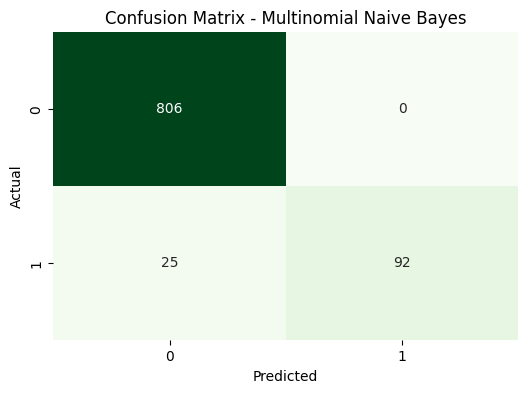

In [22]:
# Confusion Matrix Visualization
cm_mnb = confusion_matrix(y_test, y_pred_mnb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
# Detailed classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_mnb))


🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       806
         1.0       1.00      0.79      0.88       117

    accuracy                           0.97       923
   macro avg       0.98      0.89      0.93       923
weighted avg       0.97      0.97      0.97       923



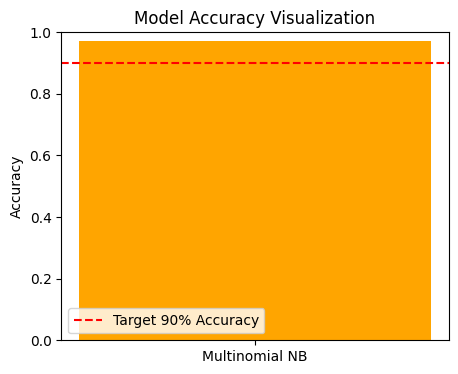

In [24]:
plt.figure(figsize=(5,4))
plt.bar(['Multinomial NB'], [mnb_accuracy], color='orange')
plt.axhline(0.9, color='red', linestyle='--', label='Target 90% Accuracy')
plt.title('Model Accuracy Visualization')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [25]:
# Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("✅ Random Forest Accuracy:", rf_accuracy * 100)


✅ Random Forest Accuracy: 98.0498374864572


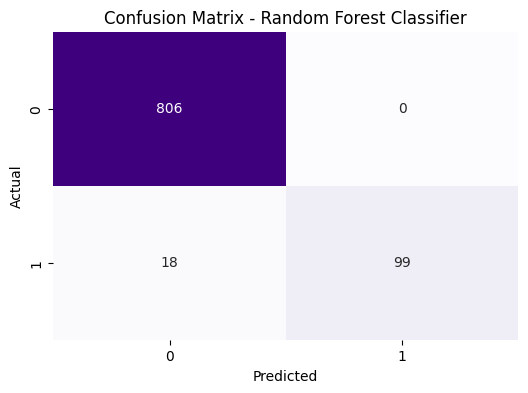

In [26]:
# Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
# Display detailed report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_rf))


🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       806
         1.0       1.00      0.85      0.92       117

    accuracy                           0.98       923
   macro avg       0.99      0.92      0.95       923
weighted avg       0.98      0.98      0.98       923



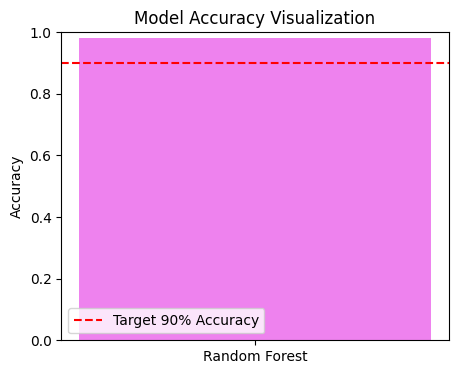

In [28]:
plt.figure(figsize=(5,4))
plt.bar(['Random Forest'], [rf_accuracy], color='violet')
plt.axhline(0.9, color='red', linestyle='--', label='Target 90% Accuracy')
plt.title('Model Accuracy Visualization')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [29]:
# Import the library
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train the XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("✅ XGBoost Classifier Accuracy:", xgb_accuracy * 100)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:37:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Classifier Accuracy: 97.29144095341279


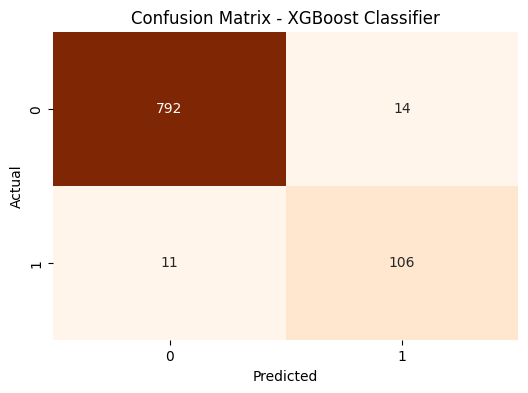

In [30]:
# Confusion Matrix Visualization
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
# Display detailed classification metrics
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_xgb))


🔍 Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       806
         1.0       0.88      0.91      0.89       117

    accuracy                           0.97       923
   macro avg       0.93      0.94      0.94       923
weighted avg       0.97      0.97      0.97       923



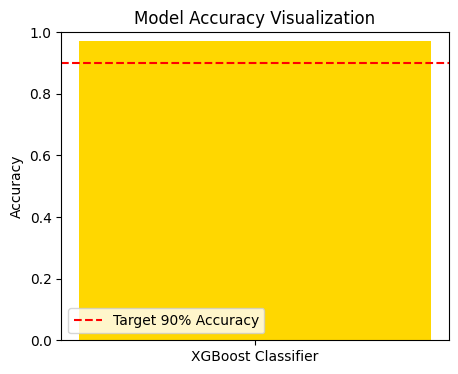

In [32]:
plt.figure(figsize=(5,4))
plt.bar(['XGBoost Classifier'], [xgb_accuracy], color='gold')
plt.axhline(0.9, color='red', linestyle='--', label='Target 90% Accuracy')
plt.title('Model Accuracy Visualization')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


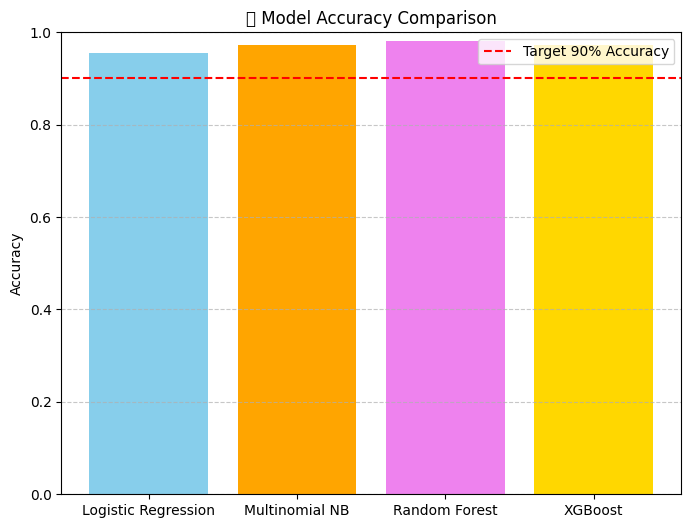

🏆 Best Model: Random Forest with Accuracy = 98.05%


In [33]:
import matplotlib.pyplot as plt

# Store all model accuracies in a dictionary
accuracies = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Multinomial NB': accuracy_score(y_test, y_pred_mnb),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'XGBoost': accuracy_score(y_test, y_pred_xgb)
}

# Plot bar chart
plt.figure(figsize=(8,6))
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'orange', 'violet', 'gold'])
plt.axhline(0.9, color='red', linestyle='--', label='Target 90% Accuracy')
plt.title('📊 Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print best model
best_model = max(accuracies, key=accuracies.get)
print(f'🏆 Best Model: {best_model} with Accuracy = {accuracies[best_model]*100:.2f}%')

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Initialize model
xgb_model = XGBClassifier(
    n_estimators=200,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage
    max_depth=6,             # Maximum depth of a tree
    random_state=42,
    eval_metric='logloss'    # Avoids warnings
)

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [37]:
# Predictions
y_pred = xgb_model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred)*100)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 97.1830985915493

Confusion Matrix:
 [[790  11]
 [ 15 107]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       801
         1.0       0.91      0.88      0.89       122

    accuracy                           0.97       923
   macro avg       0.94      0.93      0.94       923
weighted avg       0.97      0.97      0.97       923



In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Suppose you already have the same TF-IDF vectorizer used during training
new_email = ["Congratulations! You have won a free ticket to Bahamas. Click here to claim now!"]

# Transform the new email using the same vectorizer
new_email_tfidf = vectorizer.transform(new_email)

# Predict
prediction = xgb_model.predict(new_email_tfidf)

if prediction[0] == 1:
    print("🚫 Spam Email Detected")
else:
    print("✅ Ham (Not Spam) Email")


🚫 Spam Email Detected


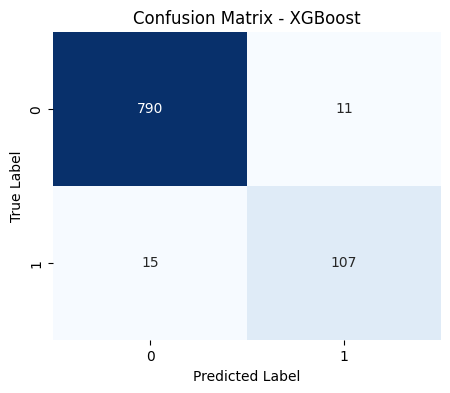

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
